# Basis Function Regression

### Autor: Carlos Andrés Arroyave
### Fecha : 11 Agosto 2025
### Mail :  caarroyave1@correo.iue.edu.co
### Movil : 3015813032
### Actividad :  Regresion lineal con funciones bases y sklearn

Este ejercio toma como base la informacion del rendimiento de estudiantes para la asignatura de Matematicas.
Las fuentes de informacion tomadas sera desde el portal 
https://archive.ics.uci.edu/dataset/320/student+performance

Si se desea descarga la fuente, puede lanzar el siguiente codigo en python.

from ucimlrepo import fetch_ucirepo 

pip install ucimlrepo

student_performance = fetch_ucirepo(id=320)  

X = student_performance.data.features 

y = student_performance.data.targets   

print(student_performance.metadata) 

print(student_performance.variables) 



## Importar librerias
Las siguientes lineas listan las librerias utilizadas en el desarrollo


In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import math
import openpyxl
from sklearn.linear_model import BayesianRidge,ARDRegression
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


## Carga de datos 
Para este bloque de codigo se tomara información de archivos cvs o excel, el codigo esta preparado para la carga

Parametros : Nombre del archivo y el tipo 
Retorna: Un Dataframe

In [96]:
def Load_Data(File, tipo):
    """Carga un archivo CSV (tipo=1) o Excel (tipo!=1)."""
    if tipo == 1:
        return pd.read_csv(File, sep=';')
    else:
        return pd.read_excel(File)

def Load_Data_FeatureTarget(Namex, Namey, File, tipo):
    """Carga datos y retorna X (Namex) y Y binarizada (>=10)."""
    df = Load_Data(File, tipo)
    #print("Cargando datos de:", File)

    # Validar columnas
    for col in Namex + [Namey]:
        if col not in df.columns:
            raise ValueError(f"La columna '{col}' no existe en el archivo.")

    X = df[Namex]
    y = df[Namey]

    

    return X, y

## Construcción matematica de las funciones

El siguiente espacio de codigo genera la formulacion matematica para las regresiones lineales basadas en funciones Power function, Sinusoidal, Gaussian
Este codigo es generado con algoritmia y no hace uso de librerias de ML

### Power Function -----> $ y = x^{n-1} $
### Sinusoidal -----> $ y = sin((k-1)*wx) $
### Gaussian -----> $ f(x) = a \, e^{-\frac{(x - b)^2}{2c^2}} $
### Sigmoid function -----> $ S(x) = frac{1}{1 + e^{-x}} $


$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
$$


In [97]:
#. Funcion de regresión lineal de polynomial
def f_Potencia(x_n, c_k):
    return x_n ** c_k -1

# funciones de regresión lineal de Gaussianas
def f_Gaussiana(x_n, c_k, sigma=0.1):
    return math.exp(-((x_n - c_k) ** 2) / (2 * sigma ** 2))

# función de regresión lineal sigmoide desplazada
def f_Sigmoide(x_n, c_k):  
    return 1 / (1 + math.exp(- (x_n - c_k)))    

def call_function(func_name, x_train, y_train, K):
   
    # Diccionario de funciones disponibles
    functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }
    
    if func_name not in functions:
        raise ValueError(f"La función '{func_name}' no está definida.")
    
    func = functions[func_name]

    # Si x es multidimensional, tomar solo una columna para la base
    if x_train.ndim > 1 and x_train.shape[1] > 1:
        x_train_1d = x_train[:, 0]
       
    else:
        x_train_1d = x_train
        

    # Matriz Phi para entrenamiento
    N = len(x_train_1d)
    Phi = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            Phi[n, k] = func(x_train_1d[n], k)
    
    # Calcular pesos con pseudoinversa
    w = np.linalg.pinv(Phi) @ y_train
    yhat = Phi @ w
    
    


    return   yhat  

## Entrenamiento de modelo 
Este bloque estará destinado a entrenar el modelo de regresión lineal, se hará uso de un modelo construido de manera manual y otro usando la librerias de Sklearn

Parametros : Feature , Target , alpha , funcion y valor K

Retorna: vectores con valores de entrenamiento

In [150]:


def FunctionEntrenar(x_base, y_base, alpha):
    idx = np.random.permutation(len(x_base))
    train_size = round(alpha * len(x_base))
    x_train = x_base[idx[:train_size]]
    y_train = y_base[idx[:train_size]]
    x_test = x_base[idx[train_size:]]
    y_test = y_base[idx[train_size:]]
    return x_train, y_train, x_test, y_test



def FunctionPredeccir(x_train,x_test, y_train, y_test, alpha, function, K):
    """Entrena un modelo de regresión lineal y grafica los resultados."""
     # Dividir en entrenamiento y prueba
  

    # Entrenar y predecir con el modelo manual , pasado los datos de test
    yhat_test = call_function(function, x_test, y_test, K)

    # Entrenar y predecir con el modelo manual , pasado los datos de train
    yhat_train  = call_function(function,  x_train, y_train, K)
    
    # Entrenar con sklearn pasando los datos de train para BayesianRidge
    modeloB = BayesianRidge()
    modeloB.fit(x_train, y_train)
    y_pred_train_Baye = modeloB.predict(x_train)
    modeloB = BayesianRidge()
    modeloB.fit(x_test, y_test)
    y_pred_test_Baye = modeloB.predict(x_test)

    modeloARD = ARDRegression()
    modeloARD.fit(x_train, y_train)
    y_pred_train_ARD = modeloARD.predict(x_train)
    
    modeloARD = ARDRegression()
    modeloARD.fit(x_test, y_test)
    y_pred_test_ARD = modeloARD.predict(x_test)


    return    yhat_test, yhat_train, y_pred_train_Baye, y_pred_test_Baye , y_pred_train_ARD, y_pred_test_ARD





def calcular_rmse(y_real, y_pred):
    """
    Calcula el RMSE de forma manual.
    Fórmula: RMSE = sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
    """
    n = len(y_real)  # número de datos
    error_cuadrado = (y_real - y_pred) ** 2  # (y_i - ŷ_i)^2
    mse = np.sum(error_cuadrado) / n  # promedio de errores cuadrados
    rmse = np.sqrt(mse)  # raíz cuadrada del MSE
    r2 = r2_score(y_real, y_pred)  # coeficiente de determinación R²
    rmse_mean = np.mean(rmse)
    rmse_std = np.std(rmse)
    r2_mean = np.mean(r2)
    r2_std = np.std(r2)
   
    return rmse, r2 




### Metodo Principal probando modelos manual y con sklearn
##### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  'data/student-mat.csv'

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'studytime'

Namey:  Variable que almacena el target  Ejemplo  Namey= 'G3'

Listado de funciones implementadas 

function = 'Gaussiana'
  functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }


--- Se muestra el acumulado luego de 30 ejecuciones  Potencia---
Modelo f_Potencia con  MEDIANA EN EL RMSE =2.7064, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9981 y STD R²=0.0000
Modelo Bayesiano con  MEDIANA EN EL RMSE =1.0062, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9997 y STD R²=0.0000
Modelo ARDRegression con  MEDIANA EN EL RMSE =1.0062, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9997 y STD R²=0.0000
El mejor modelo durante la ejecución es el  Bayesiano comparado con f_Potencia  esto se da luego de la revisión del minimo valor del  RMSE=1.0062 y maximo valor del  R²=0.9997

--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  Potencia---


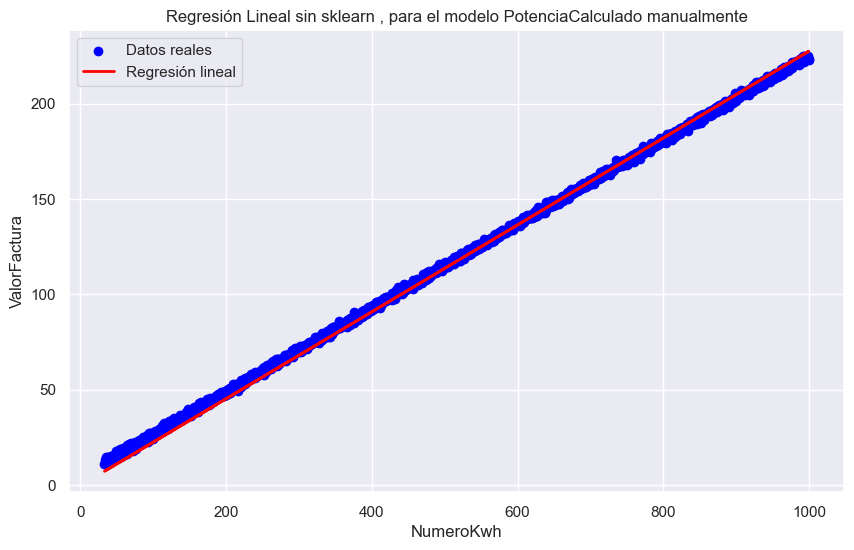


--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  BAYESIANO---


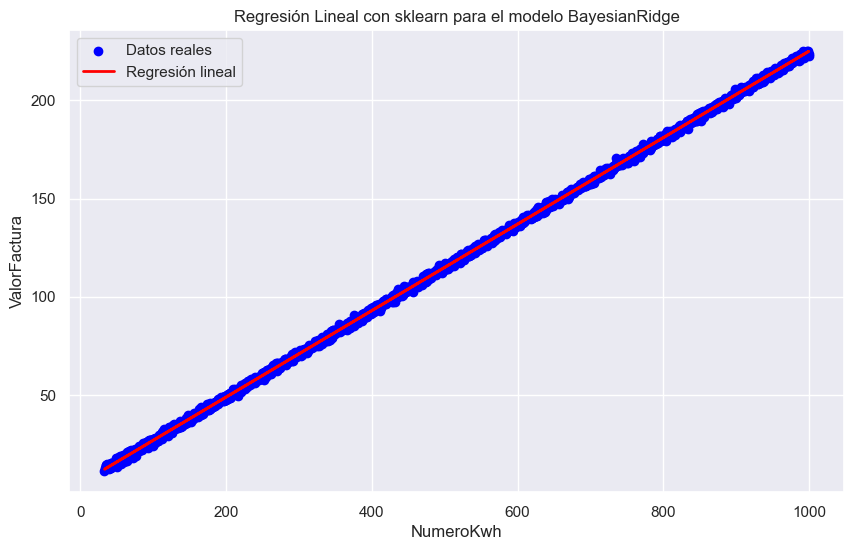


--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  ARDREGRESION---


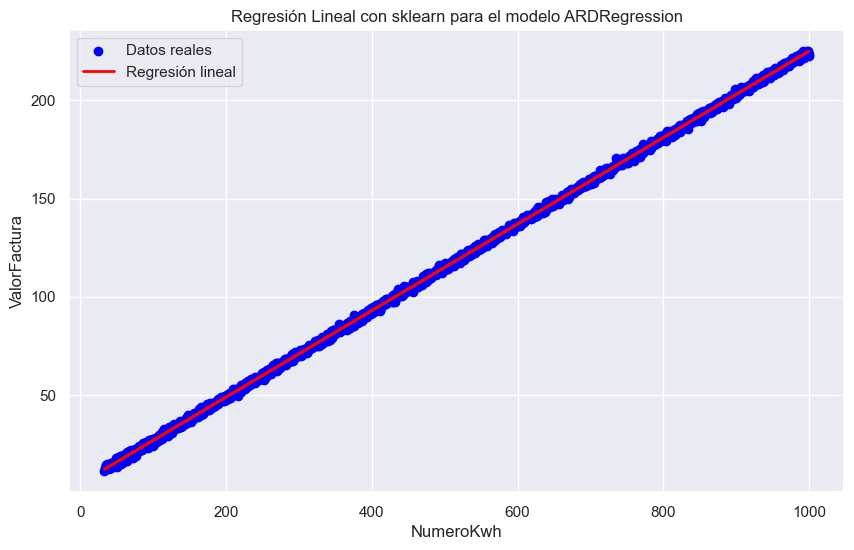


--- Se muestra el acumulado luego de 30 ejecuciones  Gaussiana---
Modelo f_Gaussiana con  MEDIANA EN EL RMSE =68.1682, y  STD EN EL RMSE =65.4618, adicionnal con MEDIANA R²=-1.2693 y STD R²=2.2674
Modelo Bayesiano con  MEDIANA EN EL RMSE =1.0062, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9997 y STD R²=0.0000
Modelo ARDRegression con  MEDIANA EN EL RMSE =1.0062, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9997 y STD R²=0.0000
El mejor modelo durante la ejecución es el  Bayesiano comparado con f_Potencia  esto se da luego de la revisión del minimo valor del  RMSE=1.0062 y maximo valor del  R²=0.9997

--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  Gaussiana---


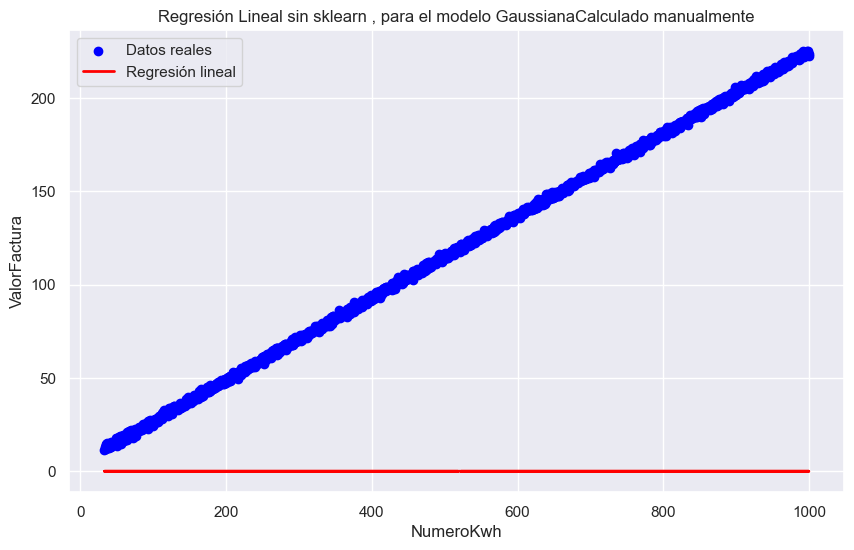


--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  BAYESIANO---


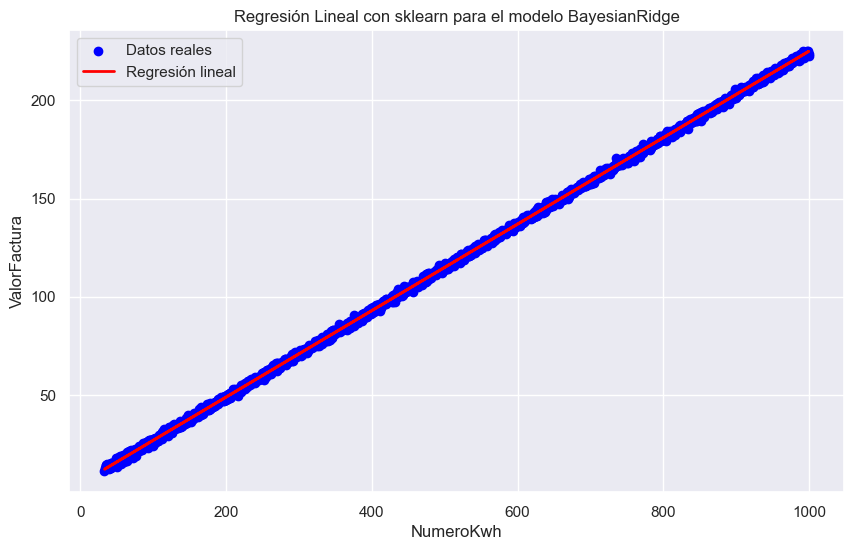


--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  ARDREGRESION---


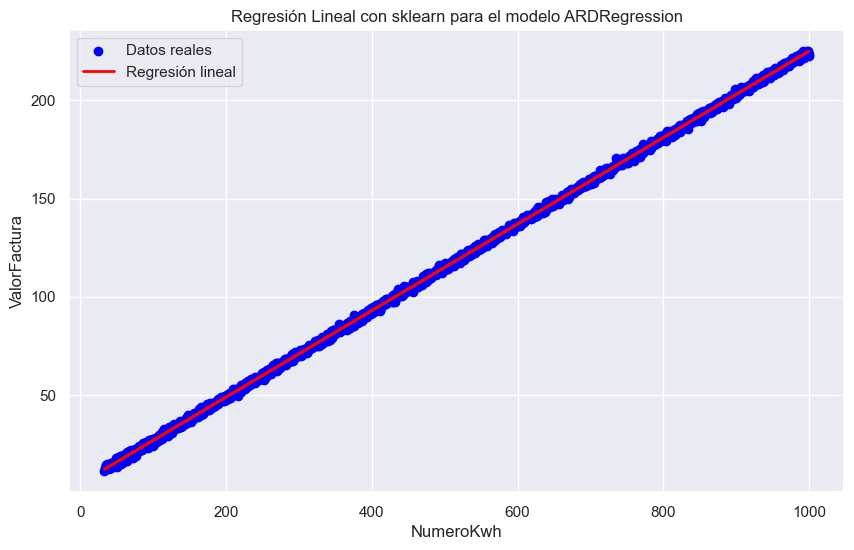


--- Se muestra el acumulado luego de 30 ejecuciones  Sigmoide---
Modelo f_Sigmoide con  MEDIANA EN EL RMSE =66.3584, y  STD EN EL RMSE =53.5106, adicionnal con MEDIANA R²=-0.8462 y STD R²=1.9456
Modelo Bayesiano con  MEDIANA EN EL RMSE =1.0062, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9997 y STD R²=0.0000
Modelo ARDRegression con  MEDIANA EN EL RMSE =1.0062, y  STD EN EL RMSE =0.0000, adicionnal con MEDIANA R²=0.9997 y STD R²=0.0000
El mejor modelo durante la ejecución es el  Bayesiano comparado con f_Potencia  esto se da luego de la revisión del minimo valor del  RMSE=1.0062 y maximo valor del  R²=0.9997

--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  Sigmoide---


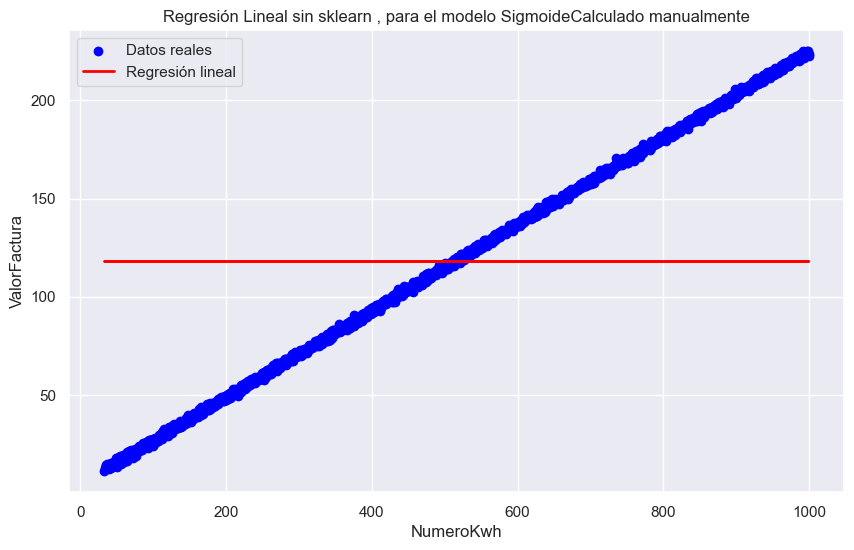


--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  BAYESIANO---


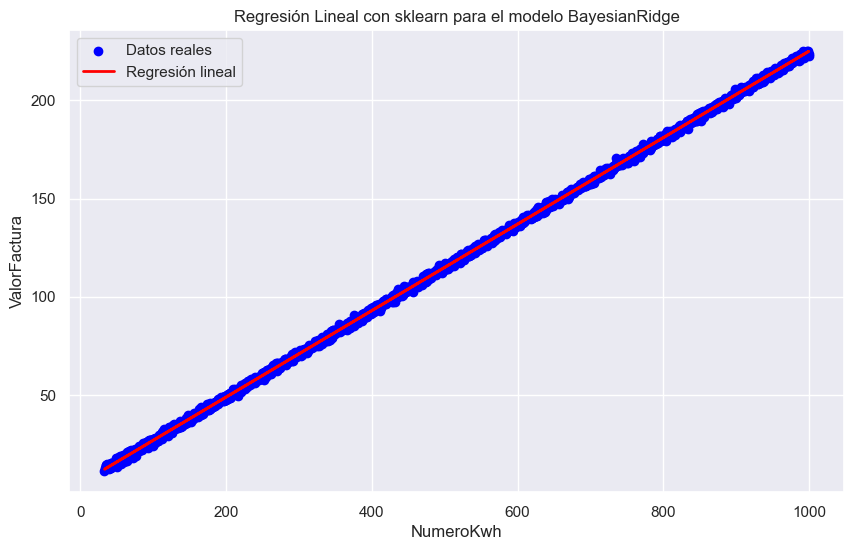


--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  ARDREGRESION---


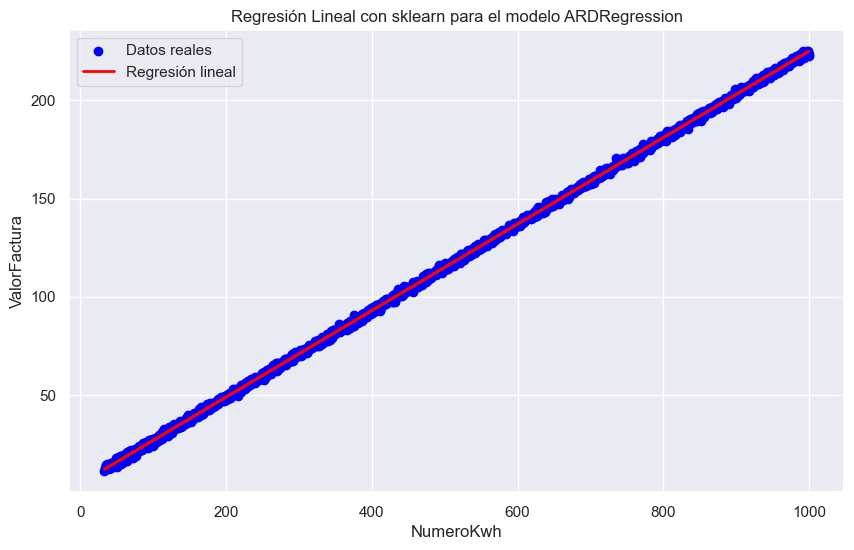

 f_Potencia: RMSE=2.7064, R²=0.9981
 Bayesiano comparado con f_Potencia : RMSE=1.0062, R²=0.9997
  ARD comparado con f_Potencia : RMSE=1.0062, R²=0.9997
 f_Gaussiana: RMSE=2.7064, R²=0.9981
 Bayesiano comparado con f_Gaussiana : RMSE=1.0062, R²=0.9997
  ARD comparado con f_Gaussiana : RMSE=1.0062, R²=0.9997
 f_Sigmoide: RMSE=2.7064, R²=0.9981
 Bayesiano comparado con f_Sigmoide : RMSE=1.0062, R²=0.9997
  ARD comparado con f_Sigmoide : RMSE=1.0062, R²=0.9997


In [158]:
if __name__ == "__main__":
    
    #File = "data/student-mat.csv"
    #Namex = ['age'] # Cambiar a la columna deseada
    #Namey = 'G3'

    File = "data/FacturaXKilovatio.csv"
    Namex = ['NumeroKwh'] # Cambiar a la columna deseada
    Namey = 'ValorFactura'
    v_functions = {
        'f_Potencia': 'Potencia',
        'f_Gaussiana': 'Gaussiana',
        'f_Sigmoide': 'Sigmoide'
    }
    
    # 
    K = 2
    alpha = 0.7
    # Cargar datos
    x_base, y_base = Load_Data_FeatureTarget(Namex, Namey, File, 1)
    # Convertir a numpy arrays
    x_base = np.array(x_base)
    y_base = np.array(y_base)

    x_train, y_train, x_test, y_test = FunctionEntrenar(x_base, y_base, alpha)
    
    repeticiones= 30
    rmse_manual_train_list, r2_manual_train_list = [], []
    rmse_Baye_train_list, r2_Baye_train_list = [], []
    rmse_ARD_train_list, r2_ARD_train_list = [], []


    resultadoscomparado = [] 
    R2_Mediana ,RMSE_Mediana = [], []
    R2_Desviacion ,RMSE_Desviacion = [],[]
    resultado = []
  

    
    for clave, funcion in v_functions.items():
        
        
        
  
  
        for _ in range(repeticiones):
        # Entrenar el modelo y obtener predicciones
            yhat_test, yhat_train, y_pred_train_Baye, y_pred_test_Baye , y_pred_train_ARD, y_pred_test_ARD = FunctionPredeccir(x_train, x_test, y_train, y_test, alpha, funcion, K)
          
          #  r2_manual_train_list, rmse_manual_test_list, r2_manual_test_list, rmse_sklearn_train_list, r2_sklearn_train_list, rmse_sklearn_test_list, r2_sklearn_test_list = RMs(y_train , yhat_train, y_test, yhat_test, y_pred_train, y_pred_test)

            v_rmse , v_r2  = calcular_rmse(y_train, yhat_train)
            rmse_manual_train_list.append (v_rmse)
            r2_manual_train_list.append(v_r2)
            

            v_rmse , v_r2 = calcular_rmse(y_train, y_pred_train_Baye)
            rmse_Baye_train_list.append (v_rmse)
            r2_Baye_train_list.append(v_r2)  

            v_rmse , v_r2 = calcular_rmse(y_train, y_pred_train_ARD)
            rmse_ARD_train_list.append (v_rmse)
            r2_ARD_train_list.append(v_r2)  




        RMSE_Mediana.append({"Modelo": f" {clave}", "RMSE": rmse_mean, "R2": r2_mean})
        RMSE_Desviacion.append ({"Modelo": f" {clave}", "RMSE": rmse_std, "R2": r2_std})
        
        resultado.append({"Modelo": f" {clave}", "RMSE": min(rmse_manual_train_list), "R2": max(r2_manual_train_list)})
        resultado.append({"Modelo": f" Bayesiano comparado con {clave} ", "RMSE": min(rmse_Baye_train_list), "R2": max(r2_Baye_train_list)})
        resultado.append({"Modelo": f"  ARD comparado con {clave} ", "RMSE": min(rmse_ARD_train_list), "R2": max(r2_ARD_train_list)})
        resultadoscomparado = min(resultado, key=lambda x: x["RMSE"])

        


        
        print(f"\n--- Se muestra el acumulado luego de 30 ejecuciones  {funcion}---")
        print(f"Modelo {clave} con  MEDIANA EN EL RMSE ={np.mean(rmse_manual_train_list):.4f}, y  STD EN EL RMSE ={np.std(rmse_manual_train_list):.4f}, adicionnal con MEDIANA R²={np.mean(r2_manual_train_list):.4f} y STD R²={np.std(r2_manual_train_list):.4f}")
        print(f"Modelo Bayesiano con  MEDIANA EN EL RMSE ={np.mean(rmse_Baye_train_list):.4f}, y  STD EN EL RMSE ={np.std(rmse_Baye_train_list):.4f}, adicionnal con MEDIANA R²={np.mean(r2_Baye_train_list):.4f} y STD R²={np.std(r2_Baye_train_list):.4f}")
        print(f"Modelo ARDRegression con  MEDIANA EN EL RMSE ={np.mean(rmse_ARD_train_list):.4f}, y  STD EN EL RMSE ={np.std(rmse_ARD_train_list):.4f}, adicionnal con MEDIANA R²={np.mean(r2_ARD_train_list):.4f} y STD R²={np.std(r2_ARD_train_list):.4f}")
      
        print(f"El mejor modelo durante la ejecución es el {resultadoscomparado['Modelo']} esto se da luego de la revisión del minimo valor del  RMSE={resultadoscomparado['RMSE']:.4f} y maximo valor del  R²={resultadoscomparado['R2']:.4f}")
    
        print(f"\n--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  {funcion}---")
        # Graficar
        plt.figure(figsize=(10, 6))
        plt.scatter(x_base[:, 0], y_base, color='blue', label='Datos reales')
        plt.plot(x_train[:, 0], yhat_train, color='red', linewidth=2, label='Regresión lineal')
        plt.xlabel(Namex[0])
        plt.ylabel(Namey)
        plt.title('Regresión Lineal sin sklearn , para el modelo ' + funcion + 'Calculado manualmente')
        plt.legend()
        plt.grid(True)
        plt.show()
     
        print(f"\n--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  BAYESIANO---")
            # Graficar los datos y la línea de regresión
        plt.figure(figsize=(10, 6))
        plt.scatter(x_base[:, 0], y_base, color='blue', label='Datos reales')
        plt.plot(x_train[:, 0], y_pred_train_Baye, color='red', linewidth=2, label='Regresión lineal')
        plt.xlabel(Namex[0])
        plt.ylabel(Namey)
        plt.title('Regresión Lineal con sklearn para el modelo BayesianRidge')
        plt.legend()
        plt.grid(True)
        plt.show()
             # Graficar los datos y la línea de regresión
        print(f"\n--- SE PRESENTA GRAFICA PARA PROCESO MANUAL DEL MODELO  ARDREGRESION---")
        plt.figure(figsize=(10, 6))
        plt.scatter(x_base[:, 0], y_base, color='blue', label='Datos reales')
        plt.plot(x_train[:, 0], y_pred_train_ARD, color='red', linewidth=2, label='Regresión lineal')
        plt.xlabel(Namex[0])
        plt.ylabel(Namey)
        plt.title('Regresión Lineal con sklearn para el modelo ARDRegression')
        plt.legend()
        plt.grid(True)
        plt.show()

        
           



# Determinar mejor por RMSE (menor valor)
mejor_rmse = min(resultado, key=lambda x: x["RMSE"])

for r in resultado:
    print(f"{r['Modelo']}: RMSE={r['RMSE']:.4f}, R²={r['R2']:.4f}")


    
# Determinar mejor por R² (mayor valor)


## Analisis de las ejecuciones 
#### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  "data/FacturaXKilovatio.csv"

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'NumeroKwh'

Namey:  Varible que contrendra el Targue.   Ejemplo NameY= 'ValorFactura'

    --- PROMEDIO DE MÉTRICAS EN 30 REPETICIONES ---

Los resultados de evaluacioón entre cada modelo comparado entre las ejecuciones manuales vs los modelos de SKlearn se imprime dentro de cada ejecución.  En conclusion el modelo Bayesiano es el mas optimo en comparación a los modelo manuales. La conclusión se obtine al ver que los RMSE mas bajo y las R2 mas cercanas a uno.

